In [1]:
import pathlib
import numpy as np
import pandas as pd

path_data = pathlib.Path().cwd().parent / 'data'

dados_train = pd.read_csv(path_data / "train.csv")

In [2]:
X = dados_train.iloc[:, :-1]
y = dados_train.iloc[:, -1].to_frame()

Classes treino: {0: 1755, 1: 1755} val: {0: 375, 1: 375} teste: {0: 375, 1: 375}
[GRID] hls=(16,), act=relu, solver=adam, eta=0.001, alpha=0.0001, bs=64, patience=30, max_epochs=300, tol=0.0001, momentum=None, nest=None, lr_policy=None
[GRID] hls=(16,), act=relu, solver=adam, eta=0.001, alpha=0.0001, bs=64, patience=30, max_epochs=500, tol=0.0001, momentum=None, nest=None, lr_policy=None
[GRID] hls=(16,), act=relu, solver=adam, eta=0.001, alpha=0.0001, bs=64, patience=30, max_epochs=700, tol=0.0001, momentum=None, nest=None, lr_policy=None
[GRID] hls=(16,), act=relu, solver=adam, eta=0.001, alpha=0.0001, bs=64, patience=30, max_epochs=1000, tol=0.0001, momentum=None, nest=None, lr_policy=None
[GRID] hls=(16,), act=relu, solver=adam, eta=0.001, alpha=0.0001, bs=64, patience=50, max_epochs=300, tol=0.0001, momentum=None, nest=None, lr_policy=None
[GRID] hls=(16,), act=relu, solver=adam, eta=0.001, alpha=0.0001, bs=64, patience=50, max_epochs=500, tol=0.0001, momentum=None, nest=None, lr_

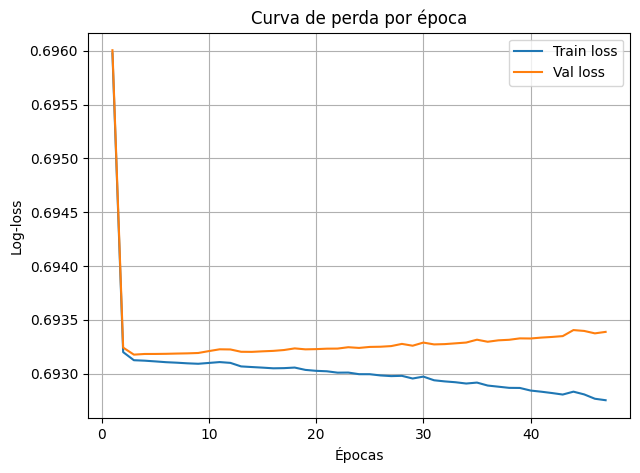

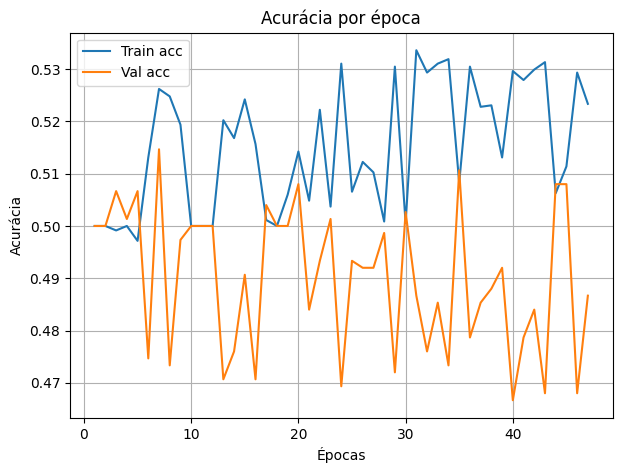

Acurácia (teste): 0.49866666666666665
F1 (teste): 0.6636851520572451
              precision    recall  f1-score   support

           0       0.43      0.01      0.02       375
           1       0.50      0.99      0.66       375

    accuracy                           0.50       750
   macro avg       0.46      0.50      0.34       750
weighted avg       0.46      0.50      0.34       750



In [3]:
import importlib, train_mlp_cv_optuna as t

t = importlib.reload(t)
from train_mlp_cv_optuna import split_70_15_15_balanced, gridsearch_mlp, plot_history
from sklearn.metrics import accuracy_score, classification_report, f1_score
import numpy as np
import warnings
from sklearn.exceptions import DataConversionWarning

warnings.filterwarnings("ignore", category=DataConversionWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# suas listas
categorical_vars = [
    "Gender",
    "Location",
    "Subscription_Type",
    "Last_Interaction_Type",
    "Promo_Opted_In",
]
continuous_vars = [
    "Age",
    "Account_Age_Months",
    "Monthly_Spending",
    "Total_Usage_Hours",
    "Streaming_Usage",
    "Discount_Used",
    "Satisfaction_Score",
]
discrete_vars = ["Support_Calls", "Late_Payments", "Complaint_Tickets"]

# 1) Split 70/15/15 balanceado
X_tr, X_va, X_te, y_tr, y_va, y_te = split_70_15_15_balanced(X, y, random_state=42)


# (sanidade) paridade
def _count(yv):
    yv = np.asarray(yv).ravel()
    return {0: int((yv == 0).sum()), 1: int((yv == 1).sum())}


print("Classes treino:", _count(y_tr), "val:", _count(y_va), "teste:", _count(y_te))

# 2) Grid: neurônios/camadas + ativações (F1 como métrica de seleção)
# param_grid = {
#     "hidden_layer_sizes": [
#         (16,), (32,), (64,), (128,),
#         (32,16), (64,32), (64,64), (128,64),
#         (128,64,32),  # 3 camadas
#         (3,),         # seu caso minimalista
#     ],
#     "activation": ["relu", "tanh", "logistic"],
# }
param_grid = {
    "hidden_layer_sizes": [
        (16,),
        (32,),
        (64,),
        (128,),
        (32, 16),
        (64, 32),
        (64, 64),
        (128, 64),
        (128, 64, 32),  # 3 camadas
        (3,),  # seu caso minimalista
    ],
    "activation": ["relu", "tanh", "logistic"],
    "solver": ["adam", "sgd"],  # 'lbfgs' será pulado (sem partial_fit)
    "learning_rate_init": [1e-3, 5e-4, 1e-4],  # etas
    "patience": [30, 50, 100, 200],  # paciência por combinação
    "max_epochs": [300, 500, 700, 1000],  # épocas máximas por combinação
}

best, trials = gridsearch_mlp(
    X_tr,
    y_tr,
    X_va,
    y_va,
    categorical_vars=categorical_vars,
    continuous_vars=continuous_vars,
    discrete_vars=discrete_vars,
    param_grid=param_grid,
    tol=1e-4,
    random_state=42,
    alpha=1e-4,
    learning_rate_init=1e-3,
    batch_size=64,
    monitor="val_f1",  # << seleciona pelo F1
    monitor_mode="max",
    verbose=1,
)

print("\n== MELHOR CONFIGURAÇÃO ==")
print(best["params"])
print(best["stats"])

# 3) Plots do melhor
plot_history(best["history"])

# 4) Teste (15%)
clf = best["clf"]
X_te_t = clf.preprocess_.transform(X_te)
y_pred = clf.predict(X_te_t)
print("Acurácia (teste):", accuracy_score(y_te, y_pred))
print("F1 (teste):", f1_score(y_te, y_pred, average="binary", pos_label=1))
try:
    print(classification_report(y_te, y_pred, target_names=dados_train.target_names))
except Exception:
    print(classification_report(y_te, y_pred))


In [ ]:
# 5) Inferência no teste e exportação CSV (Customer_ID, Churn)
import pandas as pd

OUTPUT_CSV = "test_predictions_labels.csv"

# melhor modelo do grid
clf = best["clf"]

# lê o CSV de teste (mantém índice para alinhamento)
X_teste = pd.read_csv(path_data / "test.csv")

# (opcional) garanta que não passaremos a coluna alvo por engano
if "Churn" in X_teste.columns:
    X_teste = X_teste.drop(columns=["Churn"])

# transforma e prediz
X_te_t = clf.preprocess_.transform(X_teste)          # ndarray
y_pred = clf.predict(X_te_t)
y_pred = pd.Series(y_pred, index=X_teste.index, name="Churn").astype(int)

# captura os IDs de cliente
if "Customer_ID" in X_teste.columns:
    ids = X_teste["Customer_ID"]
else:
    # fallback: usa posição como ID
    ids = pd.Series(range(len(y_pred)), index=y_pred.index, name="Customer_ID")

# monta saída e salva
preds = pd.concat([ids.reset_index(drop=True), y_pred.reset_index(drop=True)], axis=1)
preds.to_csv(OUTPUT_CSV, index=False)
print(f"Arquivo salvo em: {OUTPUT_CSV}")
preds.head()


In [ ]:
preds.value_counts("Churn")

In [ ]:
import importlib, train_mlp_cv_optuna as t
t = importlib.reload(t)
from train_mlp_cv_optuna import (
    split_70_15_15_balanced,
    gridsearch_mlp,
    summarize_trials,
    export_trials_history,
    plot_history,
)
from sklearn.metrics import accuracy_score, classification_report, f1_score
import numpy as np

# suas listas
categorical_vars = ['Gender','Location','Subscription_Type','Last_Interaction_Type','Promo_Opted_In']
continuous_vars  = ['Age','Account_Age_Months','Monthly_Spending','Total_Usage_Hours','Streaming_Usage','Discount_Used','Satisfaction_Score']
discrete_vars    = ['Support_Calls','Late_Payments','Complaint_Tickets']

# 1) Split 70/15/15 balanceado
X_tr, X_va, X_te, y_tr, y_va, y_te = split_70_15_15_balanced(X, y, random_state=42)

# 2) Grid ampliado
param_grid = {
    "hidden_layer_sizes": [(32,), (64,), (128,), (64,32), (128,64), (128,64,32)],
    "activation": ["relu", "tanh", "logistic"],
    "solver": ["adam", "sgd"],                  # 'lbfgs' será pulado (sem partial_fit)
    "learning_rate_init": [1e-3, 5e-4, 1e-4],   # etas
    "alpha": [1e-4, 1e-3],
    "batch_size": [64, 128],
    "patience": [10, 20, 30],                   # paciência por combinação
    "max_epochs": [200, 300],                   # épocas máximas por combinação
    "tol": [1e-4],                              # tol do monitor
    # extras p/ SGD:
    "momentum": [0.9],
    "nesterovs_momentum": [True],
    "learning_rate": ["constant", "adaptive"],
}

best, trials = gridsearch_mlp(
    X_tr, y_tr, X_va, y_va,
    categorical_vars=categorical_vars,
    continuous_vars=continuous_vars,
    discrete_vars=discrete_vars,
    param_grid=param_grid,
    monitor="val_f1",        # seleção por F1 de validação
    monitor_mode="max",
    random_state=42,
    verbose=1,
)

print("\n== MELHOR CONFIGURAÇÃO ==")
print(best["params"])
print(best["stats"])

# 3) Plots do melhor
plot_history(best["history"])

# 4) Avaliação no teste (15%)
clf = best["clf"]
X_te_t = clf.preprocess_.transform(X_te)
y_pred = clf.predict(X_te_t)
print("Acurácia (teste):", accuracy_score(y_te, y_pred))
print("F1 (teste):", f1_score(y_te, y_pred, average="binary", pos_label=1))
try:
    print(classification_report(y_te, y_pred, target_names=dados_train.target_names))
except Exception:
    print(classification_report(y_te, y_pred))

# 5) Salvar TODOS os resultados
summary_csv = "grid_summary_results.csv"
history_csv = "grid_history_epochs.csv"

df_summary = summarize_trials(trials, save_path=summary_csv)
df_history = export_trials_history(trials, save_path=history_csv)

print(f"Resumo salvo em: {summary_csv} (linhas: {len(df_summary)})")
print(f"Histórico por época salvo em: {history_csv} (linhas: {len(df_history)})")

# (Opcional) Top-5 por best_val_f1
display(df_summary.sort_values("best_val_f1", ascending=False).head(5))
